## **Chinese Number Identification**

This is an identification problem for hand written chinese numbers. We solve this through the use of a CNN.

Context: \
One hundred Chinese nationals took part in data collection. Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. This process was repeated 10 times with each participant. Each sheet was scanned with a resolution of 300x300 pixels.
It resulted in a dataset of 15000 images, each representing one character from a set of 15 characters (grouped in samples, grouped in suites, with 10 samples/volunteer and 100 volunteers).
This file contains the 15000 observations and 4098 columns. Columns 1 to 4096 represent each pixel of the image (64x64). The last two columns denote the value label and the original Chinese character. \
The following image shows the unique labels and characters \
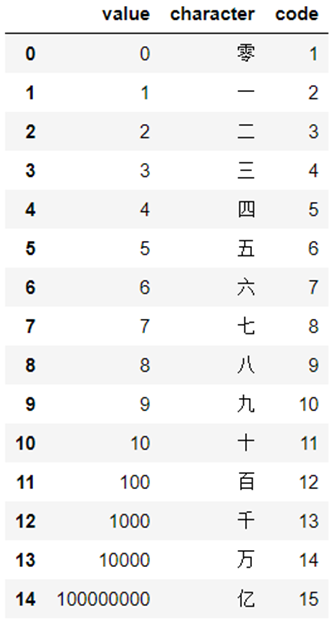

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import random
from sklearn.model_selection import train_test_split

### Step 1
Read in the data as a dataframe and gain an understanding of what we are looking at.

In [2]:
dataframe=pd.read_csv("chineseMNIST.csv")
print(dataframe.head())

   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4088  pixel_4089  pixel_4090  pixel_4091  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  character  
0         

Most of the columns, aside from the last two, are the pixel values that form each image. The label column shows the numerical label given to it, while the character column is the actual Chinese column associated with that label.

### Step 2
Prepare the data.

First, we can separate the dataframe into 2 separate variables. The x variable will be an np array with all of the pixel values, meaning we drop the 'label' and 'character' columns. The y variable will be an np array with just the label column.

In [3]:
x = np.array(dataframe.drop(columns = ['label','character'])) #remove label and character columns
y = np.array(dataframe['label']) #y is defined only by the label column

First, let's deal with the x array. Since these are the pixel values, we must scale them. Below is a very simple way we can implement this scaling.

In [4]:
# Scale the pixel values
x = x.astype('float32')
x /= 255

Now, we must create a conversion to account for the label-to-character pipeline. We first establish a dictionary to convert the values to code.
We then create another dictionary that will convert the code to the Chinese characters.

With this, we can now encode the y variable into a y_coded np array.

In [5]:
code = {0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:10,100:11,1000:12,10000:13,100000000:14}
character = {0:'零',1:'一',2:'二',3:'三',4:'四',5:'五',6:'六',7:'七',8:'八',9:'九',10:'十',11:'百',12:'千',13:'万',14:'亿'}
y_coded = []
i = 0
while i < len(y):
  y_coded.append(code[y[i]])
  i += 1
y_coded = np.array(y_coded)

With the variables in the proper setup, we can take a moment to explore the data a little more.

First, let's plot the number of each Chinese number.

<ipython-input-6-6bd03492b826>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(character.values(),fontproperties=myfont)


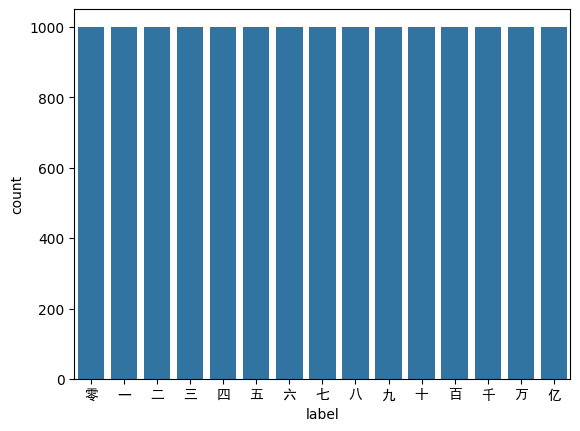

In [6]:
plt.figure(1)
myfont = matplotlib.font_manager.FontProperties(fname=r"SimHei.ttf")
ax = sb.countplot(x="label", data=dataframe)
ax.set_xticklabels(character.values(),fontproperties=myfont)
plt.show()

Next, let's visualize 25 random characters.
We can ensure that our conversions are working by displaying both the English and Chinese numbers. (We must remember to reshape each row so that our pixels display in a 64 x 64 format.)

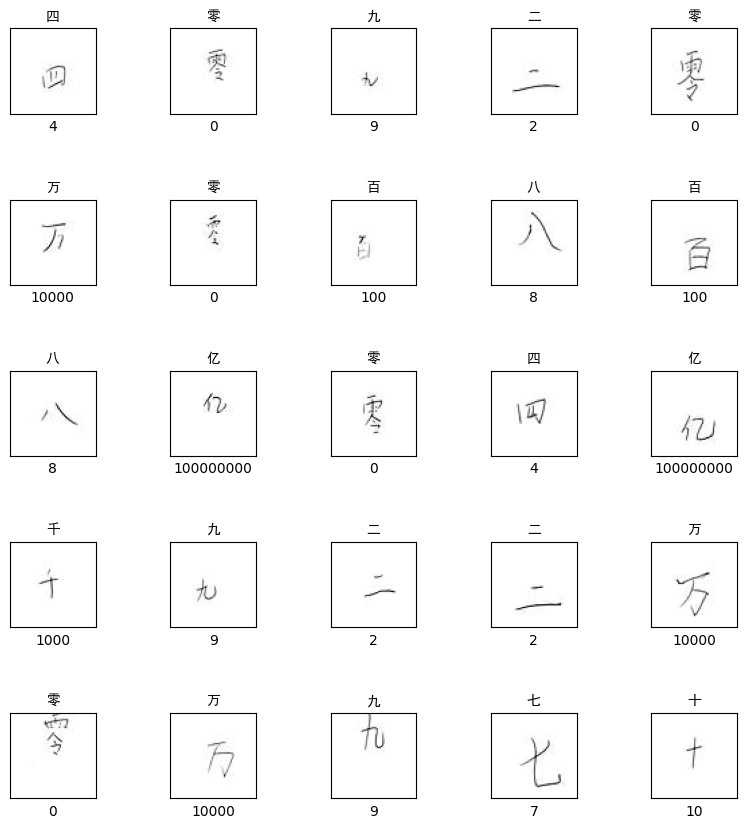

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    r = random.randint(1, dataframe.shape[0]) # Visualize a random row in the dataset
    pixel = x[r]
    pixel = np.array(pixel)
    pixel = pixel.reshape(64,64) # Shape pixels as a bbb x bbb array
    plt.imshow(pixel, cmap=plt.cm.binary)
    plt.title(character[y_coded[r]],fontproperties=myfont)
    plt.xlabel(y[r])
plt.subplots_adjust(hspace=1)
plt.show()


### Step 3
Now that we have the x and y variables set, we can partition the data. \
A key point here is that we must implement the reshaping of the x variable into a 64 x 64 shape. We can print out the shapes of each variable out using .shape, as it will be crucial for formatting the model layers.

In [8]:
X_train, X_test , Y_train, Y_test = \
    train_test_split(x, y_coded,test_size=0.30, random_state=2023, stratify=y_coded)
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_Test:",Y_test.shape)
X_train = np.reshape(X_train, (-1, 64,64)) #reshaping
X_test = np.reshape(X_test, (-1,64,64))
print("Reshaped X_train:",X_train.shape)
print("Reshaped X_test:",X_test.shape)

X_train: (10500, 4096)
Y_train: (10500,)
X_test: (4500, 4096)
Y_Test: (4500,)
Reshaped X_train: (10500, 64, 64)
Reshaped X_test: (4500, 64, 64)


### Step 4
Build a stack of layers with the sequential model.
The different layers we can utilize are:
- Conv2D
 - A filter/kernel "slides" over the 2D data to perform element-wise multiplication.
- MaxPool2D
 - Downsamples the input along is spatial dimensions by taking the maximum value over an input window.
- Dropout
 - Randomly deactivates some inputs to prevent overfitting
- Flatten
 - Reshapes the output into a dimensional vector, and is used to transition from a convolution layer to a fully connected layer.
- Dense
 - Performs a linear operation on the layer's input vector (dot product).

In [9]:
with tf.device("/GPU:0"):
  model = Sequential()

  model.add(Conv2D(50,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',
                  input_shape=(64,64,1)))
  model.add(Conv2D(75,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Dropout(.25))
  model.add(Conv2D(100,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(.25))
  model.add(Flatten())

  model.add(Dense(500,activation='relu'))
  model.add(Dropout(.4))
  model.add(Dense(250,activation='relu'))
  model.add(Dropout(.3))

We can then run a model.summary() to print out information about the layers.

In [10]:
  model.add(Dense(15,activation='softmax'))
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 50)        500       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 75)        33825     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 75)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 100)       67600     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 100)       0         
 g2D)                                                   

### Step 5
Compile and train the model.

For the compiling step, we must choose our loss function. For our case, we will be using a sparse_cateogrical_crossentropy loss function.

For the training step, we must set certain parameters relating to the epoch. An epoch is the training of the neural network with all the training data for one cycle. The batch_size determines the number of samples we use in one epoch, while the epoch parameter sets the number of epochs the model will run.

In [11]:
# Use the loss function sparse_categorical_crossentropy when compiling the model

#compile
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#train
history=model.fit(X_train,Y_train,batch_size=64,epochs=25,validation_data=(X_test,Y_test))

Epoch 1/25
165/165 [==============================] - 15s 50ms/step - loss: 1.2740 - accuracy: 0.5881 - val_loss: 0.3984 - val_accuracy: 0.8653
Epoch 2/25
165/165 [==============================] - 7s 42ms/step - loss: 0.3893 - accuracy: 0.8686 - val_loss: 0.2148 - val_accuracy: 0.9271
Epoch 3/25
165/165 [==============================] - 7s 43ms/step - loss: 0.2282 - accuracy: 0.9250 - val_loss: 0.1166 - val_accuracy: 0.9620
Epoch 4/25
165/165 [==============================] - 7s 42ms/step - loss: 0.1466 - accuracy: 0.9520 - val_loss: 0.0883 - val_accuracy: 0.9731
Epoch 5/25
165/165 [==============================] - 8s 47ms/step - loss: 0.1051 - accuracy: 0.9653 - val_loss: 0.0975 - val_accuracy: 0.9693
Epoch 6/25
165/165 [==============================] - 7s 43ms/step - loss: 0.0908 - accuracy: 0.9711 - val_loss: 0.0791 - val_accuracy: 0.9733
Epoch 7/25
165/165 [==============================] - 7s 43ms/step - loss: 0.0653 - accuracy: 0.9773 - val_loss: 0.0953 - val_accuracy: 0.970

We can see that by the time this model is reaching 25 epochs, the accuracy is hitting over 99%, and the validation accuracy is over 98%, meaning our model is working very well.

### Step 6
Analyze the model by looking at the loss curve and the accuracy curve.


Text(0.5, 1.0, 'Accuracy Curve')

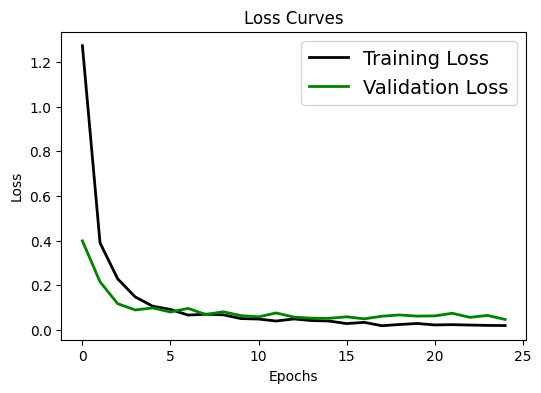

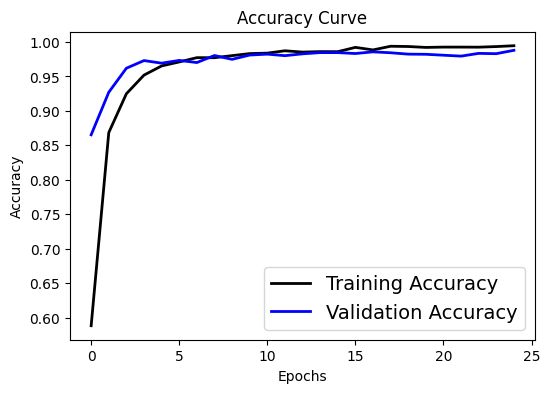

In [12]:
# Plot the loss and accuracy curves for both train and test partitions.
#loss curve
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'black',linewidth=2.0)
plt.plot(history.history['val_loss'],'green',linewidth=2.0)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=12)

#accuracy curve
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],'black',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'blue',linewidth=2.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.title('Accuracy Curve',fontsize=12)

### Step 7
Making actual predictions

Now that we have a working model, we can make actual predictions. \
We must note here that when we predict from the model, we must use argmax to convert into a label index, and then input the label index into the class_names list to get the actual categorical label.

141/141 [==============================] - 1s 4ms/step


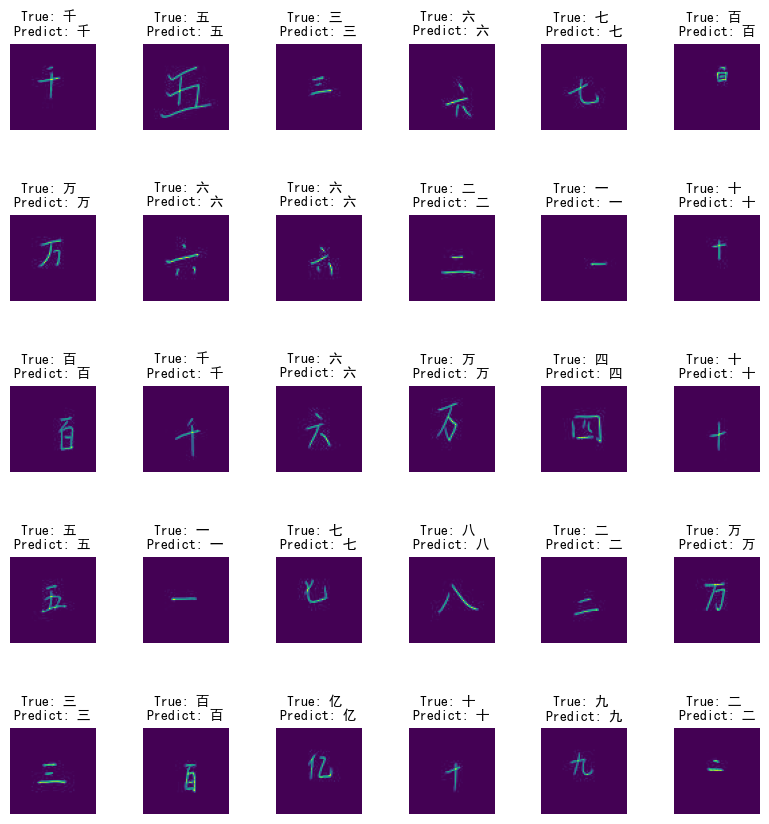

In [13]:
# Visualize the predicted and actual image labels (in Chinese characters) for the first 30 images in the dataset.

#predictions
pred=model.predict(X_test)
# convert into label index
pred_classes=np.argmax(pred, axis=1)

#plot actual vs predicted
plt.figure(figsize=[10,10])
for i in range (30):
  plt.subplot(5,6,i+1).imshow(X_test[i])
  plt.subplot(5,6,i+1).set_title("True: %s \nPredict: %s" %
                                 (character[Y_test[i]],
                                  character[pred_classes[i]]),fontproperties=myfont)
  plt.subplot(5,6,i+1).axis('off')
plt.subplots_adjust(hspace=1)
plt.show()

If we want to look at just the misclassified labels, we can run the following.

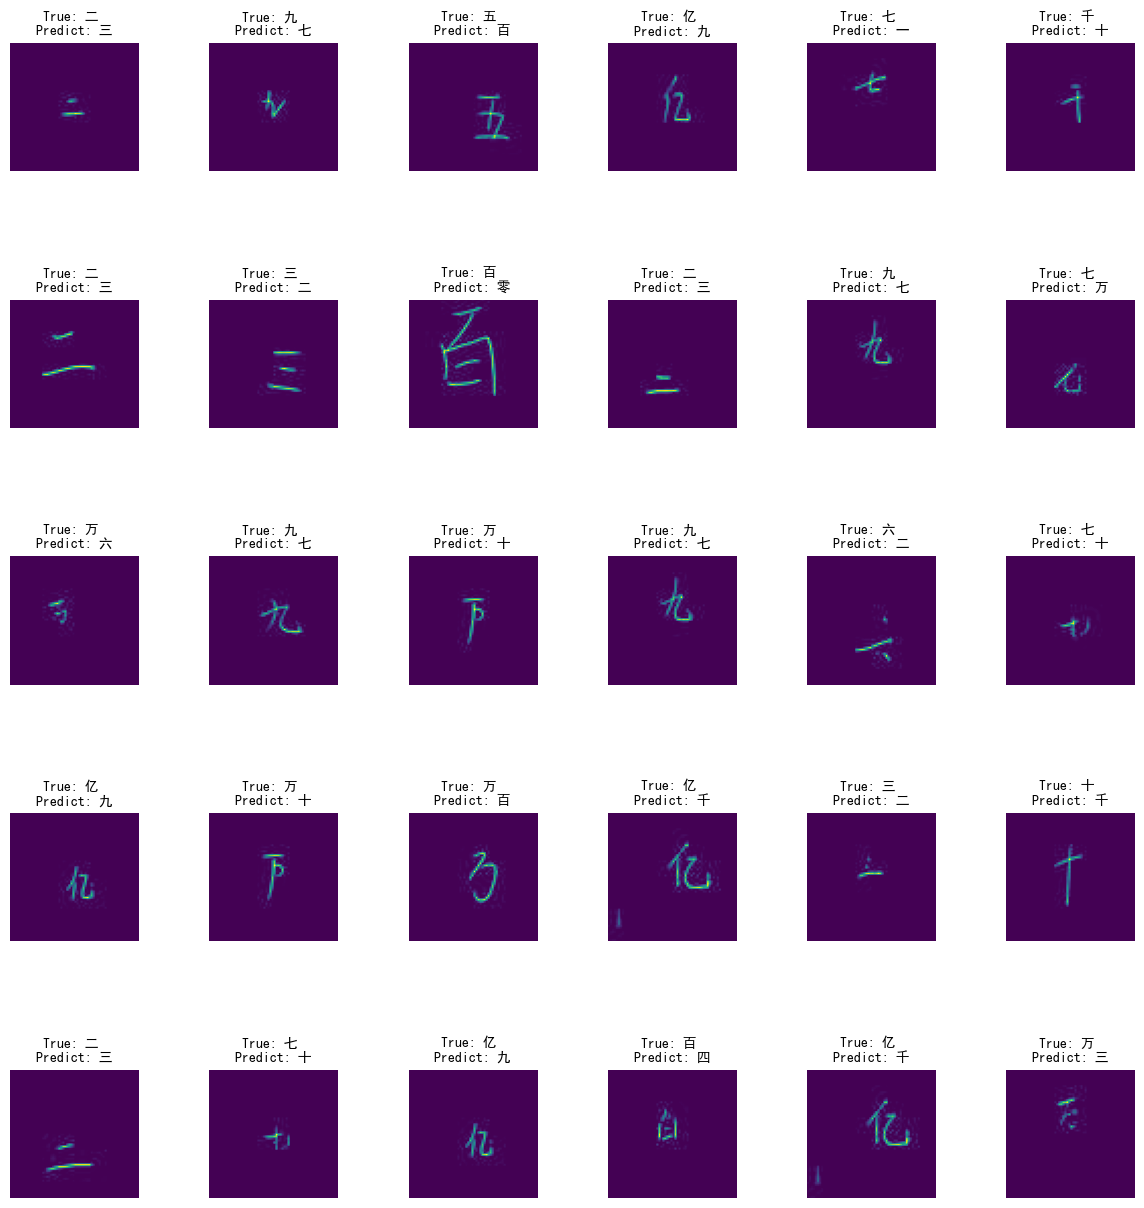

In [14]:
# Visualize 30 random misclassified images. Display the Chinese characters for both the predicted and actual image labels.

#misclassified results
failed_indices = []
idx =0

for i in Y_test:
  if i != pred_classes[idx]:
    failed_indices.append(idx)
  idx=idx+1

plt.figure(figsize=[15,15])

for i in range(30):
  # for first 30 use
  # failed_index = failed_indices[i]
  random_select = np.random.randint(0,len(failed_indices))
  failed_index = failed_indices[random_select]
  plt.subplot(5,6,i+1).imshow(X_test[failed_index])
  plt.subplot(5,6,i+1).set_title("True: %s \nPredict: %s" %
                                 (character[Y_test[failed_index]],
                                  character[pred_classes[failed_index]]),fontproperties=myfont)
  plt.subplot(5,6,i+1).axis('off')

plt.subplots_adjust(hspace=1)
plt.show()